# Nonlinear bias using generalized tracers and power spectra
This example showcases how to do nonlinear biasing with the generalized tracers and 2D power spectra implemented in CCL. First we show how this is done explicitly with most functions outside of CCL. Then we show the CCL functionality that does the same thing. We could use a comparison like this as a unit test in the future.

For more on generalized tracers and power spectra, see GeneralizedTracers.ipynb

In [77]:
import numpy as np
import pylab as plt
import pyccl as ccl
%matplotlib inline

## Preliminaries
Let's just begin by setting up a cosmology and a couple of redshift distributions and bias functions

In [78]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Redshift-dependent functions
z = np.linspace(0,1.2,1024)
# Redshift distributions
nz1 = np.exp(-((z-0.5)/0.05)**2/2)
nz2 = np.exp(-((z-0.65)/0.05)**2/2)
# growth factor
gz = ccl.growth_factor(cosmo,1./(1+z))
# Bias
b_1 = 2.0 # constant values for now
b_2 = 1.0
b_s = 1.0
# Magnification bias
sz = np.ones_like(z)
# Intrinsic alignment amplitude
az = -0.004 * np.ones_like(z)
# The scale factor values need to be increasing, so we'll reverse
# The order of all arrays:
sf = (1./(1+z))[::-1]
transfer_a = (sf,bz[::-1])
ga = ccl.growth_factor(cosmo,sf)

## Standard tracers
There are a set of standard tracers with built-in constructors.
First, there is number counts tracers (a.k.a. galaxy clustering). These include the standard contribution from the matter overdensity multiplied by a linear, scale-independent bias, redshift-space distortions and magnification. You can turn off any of them.

In [79]:
# This tracer will only include the density contribution
gc_d = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz), mag_bias=None)
# If you pass bias=None, then the tracer will not have a density term. E.g. this one is an RSD-only tracer.
gc_r = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z,nz1), bias=None, mag_bias=None)
# Now a magnification-only tracer. To turn on magnification just pass a non-None mag_bias.
gc_m = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=None, mag_bias=(z,sz))
# You can of course create a tracer that includes all of these terms
gc_a = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z,nz1), bias=(z,bz), mag_bias=(z,sz))

There are also standard weak lensing tracers with two terms: the cosmic shear term due to lensing and intrinsic alignments within the L-NLA model with a scale-independent IA amplitude. We will show in this notebook how to include a nonlinear IA model.

In [80]:
# This tracer will only include the lensing shear contribution (by setting the ia_bias to None)
wl_s = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=True, ia_bias=None)
# This tracer will only include IAs
wl_i = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=False, ia_bias=(z,az))
# And you can have the full monty
wl_a = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=True, ia_bias=(z,az))

Finally, we also have CMB lensing tracers, defined by a single source redshift.

In [81]:
# We put the source at z=1100, but you can put it at any other redshift if you want to!
# It won't be CMB lensing though.
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1100.)

## Generalized power spectra

By default, when you call `ccl.angular_cl`, CCL will use the non-linear matter power spectrum in the equation for $C_\ell$ above to compute the angular power spectrum. You can however, pass a more general `Pk2D` object. These objects encapsulate generic power spectra that depend simultaneously on $k$ and $a$. They are versatile and can be created in different ways, but for our purposes here, we will generate them using the nonlinear modeling tool FAST-PT.

In [82]:
#Get the linear power spectrum at z=0 for our given cosmology
# k array to be used for power spectra
ks = np.logspace(-5,2,512)
pk_lin_z0 = ccl.linear_matter_power(cosmo,ks,1)

In [83]:
#import FAST-PT and set settings.
import fastpt as fpt

do_bias = True
to_do = []
if do_bias:
    to_do.append('dd_bias')
#other functionality (e.g. IA terms or RSD) can be added here for FASTPT.
#Ideally, the initialization happens once per likelihood evaluation, or even once per chain.
pad_factor=1
low_extrap=-5
high_extrap=3
P_window=None
C_window=.75

n_pad = pad_factor*len(ks)

In [84]:
#initialize FAST-PT object
fpt_obj=fpt.FASTPT(ks,to_do=to_do,low_extrap=low_extrap,high_extrap=high_extrap,n_pad=n_pad)

In [85]:
#calculate nonlinear bias terms
bias_fpt = fpt_obj.one_loop_dd_bias(pk_lin_z0,P_window=P_window,C_window=C_window)

In [86]:
#define functions that calculate P_mg and P_gg using FAST-PT outputs
def pk_gg_PT(b1,b2,bs,bias_fpt,sub_lowk=True,use_nonlin=True):
    # needs to allow different bias values for different tracers.
    # needs to allow bias as a function of z
    if use_nonlin:
        pk_array = np.array([ccl.nonlin_matter_power(cosmo,ks,a) for a in sf])
    else:
        pk_array = np.array([ccl.linear_matter_power(cosmo,ks,a) for a in sf])
    Pd1d2 = np.array([g ** 4 * bias_fpt[2] for g in ga]) #replace with np.outer?
    Pd2d2 = np.array([g ** 4 * bias_fpt[3] for g in ga])
    Pd1s2 = np.array([g ** 4 * bias_fpt[4] for g in ga])
    Pd2s2 = np.array([g ** 4 * bias_fpt[5] for g in ga])
    Ps2s2 = np.array([g ** 4 * bias_fpt[6] for g in ga])
    sig4ka = 0.
    if sub_lowk:
        sig4ka = np.array([g ** 4 * bias_fpt[7] * np.ones_like(bias_fpt[0]) for g in ga])
    
    p_gg = (b1**2*pk_array + b1*b2*Pd1d2 + (1./4)*b2*b2*(Pd2d2-2.*sig4ka) + b1*bs*Pd1s2 +
            (1./2)*b2*bs*(Pd2s2-4./3*sig4ka) + (1./4)*bs*bs*(Ps2s2-8./9*sig4ka))
    return p_gg

def pk_gm_PT(b1,b2,bs,bias_fpt,use_nonlin=True):
    if use_nonlin:
        pk_array = np.array([ccl.nonlin_matter_power(cosmo,ks,a) for a in sf])
    else:
        pk_array = np.array([ccl.linear_matter_power(cosmo,ks,a) for a in sf])
    Pd1d2 = np.array([g ** 4 * bias_fpt[2] for g in ga]) #replace with np.outer? pd1d2 = ga[:,None]**2 * bias_fpt[2][None,:]
    Pd2d2 = np.array([g ** 4 * bias_fpt[3] for g in ga])
    Pd1s2 = np.array([g ** 4 * bias_fpt[4] for g in ga])
    Pd2s2 = np.array([g ** 4 * bias_fpt[5] for g in ga])
    Ps2s2 = np.array([g ** 4 * bias_fpt[6] for g in ga])
    
    p_gm = b1*pk_array + (1./2)*b2*Pd1d2 + (1./2)*bs*Pd1s2
    return p_gm

In [87]:
#calculate some power spectra
b1=b_1
b2=b_2
bs=b_s

p_gg = pk_gg_PT(b1,b2,bs,bias_fpt)
p_gm = pk_gm_PT(b1,b2,bs,bias_fpt)
# Create Pk2D objects out of these
pk_gg = ccl.Pk2D(a_arr=sf, lk_arr=np.log(ks), pk_arr=p_gg, is_logp=False)
pk_gm = ccl.Pk2D(a_arr=sf, lk_arr=np.log(ks), pk_arr=p_gm, is_logp=False)

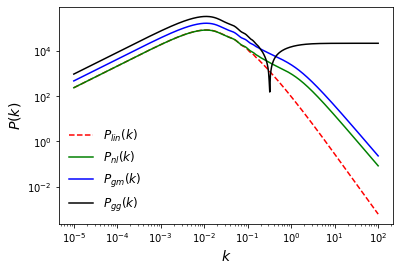

In [88]:
#Plot stuff
pk_nl_array = np.array([ccl.nonlin_matter_power(cosmo,ks,a) for a in sf])
plt.plot(ks,pk_lin_z0, 'r--', label='$P_{lin}(k)$')
plt.plot(ks,pk_nl_array[-1], 'g-', label='$P_{nl}(k)$')
plt.plot(ks,p_gm[-1], 'b-', label='$P_{gm}(k)$')
plt.plot(ks,abs(p_gg[-1]), 'k-', label='$P_{gg}(k)$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('$P(k)$', fontsize=14)
plt.legend(loc='lower left', fontsize=12, frameon=False)

In [89]:
# Define some new tracers that use nonlinear biasing

# This tracer will only include the density contribution. Bias must be 1 with the current setup, which applies bias with P(k)
bz1=np.ones_like(z)
gc_d1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz1), mag_bias=None)
gc_d2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz1), mag_bias=None)
# where will we specify bias values?

# tracers for the test with halofit
bz_hf=b_1*np.ones_like(z)
gc_d1_hf = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz_hf), mag_bias=None)
gc_d2_hf = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz_hf), mag_bias=None)

In [90]:
#Calculate C_ells
ells = np.geomspace(2,1000,20)

cl_gc_nonlin_old = ccl.angular_cl(cosmo, gc_d1, gc_d2, ells, p_of_k_a=pk_gg)
cl_ggl_nonlin_old = ccl.angular_cl(cosmo, gc_d1, wl_s, ells, p_of_k_a=pk_gm)

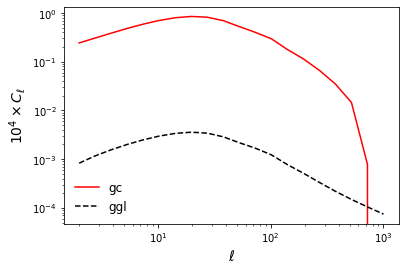

In [91]:
# Plot stuff
plt.plot(ells, 1E4*cl_gc_nonlin_old, 'r-', label='gc')
plt.plot(ells, 1E4*cl_ggl_nonlin_old, 'k--', label='ggl')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize=14)
plt.ylabel('$10^4\\times C_\\ell$', fontsize=14)
plt.legend(loc='lower left', fontsize=12, frameon=False)
plt.show()

In [92]:
PTTracer1 = ccl.PTNumberCountsTracer(b1=b_1,b2=b_2,bs=b_s)
PTTracer2 = ccl.PTNumberCountsTracer(b1=b_1,b2=b_2,bs=b_s)
PTmatter = ccl.PTNumberCountsTracer(b1=1.0) # this is a temporary hack. b1=1 is equivalent to DM.

In [93]:
pk_gg=ccl.get_pt_pk(cosmo, ks, sf, tracer_1=PTTracer1, tracer_2=PTTracer2,
              pt_object=None, return_pt_object=False, sub_lowk=True, use_nonlin=True)
pk_gm=ccl.get_pt_pk(cosmo, ks, sf, tracer_1=PTTracer1, tracer_2=PTmatter,
              pt_object=None, return_pt_object=False, sub_lowk=True, use_nonlin=True)

In [94]:
#use those power spectra to calculate C_ells.
cl_gc_nonlin = ccl.angular_cl(cosmo, gc_d1, gc_d2, ells, p_of_k_a=pk_gg)
cl_ggl_nonlin = ccl.angular_cl(cosmo, gc_d1, wl_s, ells, p_of_k_a=pk_gm)

#or do it all in one step, which is probably what we want to do to use the tracer info properly.
#this shows why we want to link the two different types of tracers.
cl_gc_nonlin2 = ccl.angular_cl(cosmo, gc_d1, gc_d2, ells, p_of_k_a=ccl.get_pt_pk(cosmo, ks, sf, tracer_1=PTTracer1, tracer_2=PTTracer2,
              pt_object=None, return_pt_object=False, sub_lowk=True, use_nonlin=True))
cl_ggl_nonlin2 = ccl.angular_cl(cosmo, gc_d1, wl_s, ells, p_of_k_a=ccl.get_pt_pk(cosmo, ks, sf, tracer_1=PTTracer1, tracer_2=PTmatter,
              pt_object=None, return_pt_object=False, sub_lowk=True, use_nonlin=True))

In [95]:
# Now let's calculate a few quantities with the standard (nonlinear) power spectrum for comparison.

cl_gc_halofit = ccl.angular_cl(cosmo, gc_d1_hf, gc_d2_hf, ells)
cl_ggl_halofit = ccl.angular_cl(cosmo, gc_d1_hf, wl_s, ells)

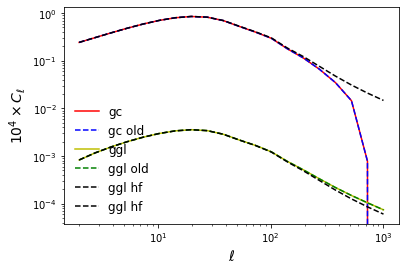

In [96]:
# Plot stuff
plt.plot(ells, 1E4*cl_gc_nonlin2, 'r-', label='gc')
plt.plot(ells, 1E4*cl_gc_nonlin_old, 'b--', label='gc old')
plt.plot(ells, 1E4*cl_ggl_nonlin2, 'y-', label='ggl')
plt.plot(ells, 1E4*cl_ggl_nonlin_old, 'g--', label='ggl old')
plt.plot(ells, 1E4*cl_gc_halofit, 'k--', label='ggl hf')
plt.plot(ells, 1E4*cl_ggl_halofit, 'k--', label='ggl hf')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize=14)
plt.ylabel('$10^4\\times C_\\ell$', fontsize=14)
plt.legend(loc='lower left', fontsize=12, frameon=False)
plt.show()

In [97]:
# Finally, let's do some correlation functions
theta_deg = np.logspace(-1, np.log10(5.), 20) # Theta is in degrees

#Clustering:
#xi_clu = ccl.correlation(cosmo, ells, cl_gc_nonlin2, theta_deg, corr_type='GG', method='FFTLog')
# Note, after updating numpy, the above integral appears to crash.
# It is clearly numerically unstable, but it was not crashing before.

#galaxy-galaxy lensing

xi_ggl = ccl.correlation(cosmo, ells, cl_ggl_nonlin2, theta_deg, corr_type='GL', method='FFTLog')

xi_clu_halofit = ccl.correlation(cosmo, ells, cl_gc_halofit, theta_deg, corr_type='GG', method='FFTLog')
xi_ggl_halofit = ccl.correlation(cosmo, ells, cl_ggl_halofit, theta_deg, corr_type='GL', method='FFTLog')


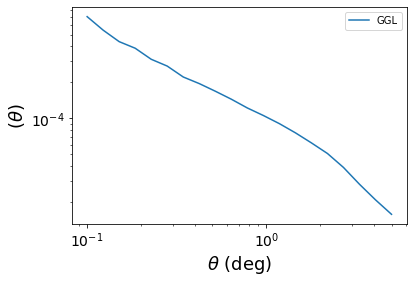

In [98]:
#And plot the results
#plt.plot(theta_deg, xi_clu, label='Clustering') #not plotting the unstable one.
plt.plot(theta_deg, xi_ggl, label='GGL')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$(\theta)$',fontsize=18)
plt.show()

In [99]:
#It looks like the sublowk clustering power spectrum is causing problems. Let's try again keeping the original low k behavior
cl_gc_nonlin_lowk = ccl.angular_cl(cosmo, gc_d1, gc_d2, ells, p_of_k_a=ccl.get_pt_pk(cosmo, ks, sf, tracer_1=PTTracer1, tracer_2=PTTracer2,
              pt_object=None, return_pt_object=False, sub_lowk=False, use_nonlin=True))
xi_clu_lowk = ccl.correlation(cosmo, ells, cl_gc_nonlin_lowk, theta_deg, corr_type='GG', method='FFTLog')

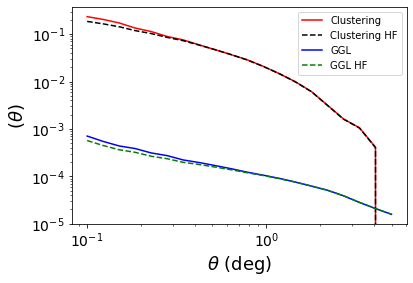

In [103]:
#And plot the comparison
#plt.plot(theta_deg, xi_clu, label='Clustering sub lowk')
plt.plot(theta_deg, xi_clu_lowk, 'r-', label='Clustering')
plt.plot(theta_deg, xi_clu_halofit, 'k--', label='Clustering HF')
plt.plot(theta_deg, xi_ggl, 'b-', label='GGL')
plt.plot(theta_deg, xi_ggl_halofit, 'g--',label='GGL HF')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$(\theta)$',fontsize=18)
plt.show()

In [101]:
# Indeed, it looks like the sublowk option does not interact well with the current fourier transform methods.
# After updating numpy, the sublowk option appears not to converge with the FFT.

In [ ]:
# Finally, let's explore the behavior of the FFT with high-k vs low-k. 
#xi_clu = ccl.correlation(cosmo, ells, cl_gc_nonlin2, theta_deg, corr_type='GG', method='FFTLog')